In [1]:
# load libraries
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from fxns import *
import datetime as dt
import seaborn as sns
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# load data
df = pd.read_csv("data/dist.csv", parse_dates=True)
df.rename(columns={'value':'distance'}, inplace=True) # rename "value"
df = df[['distance', 'creationDate']] # relevant values

# use function to convert dates to date values, get days/month/year
check_dates(df)
df['creationDate'] = df['creationDate'].dt.date

# group by date
df = df.groupby('creationDate', as_index=False)['distance'].sum()

# parse date info
check_dates(df) # check for dates again after grouping
df['year'] = df['creationDate'].dt.year
df['month_name'] = df['creationDate'].dt.month_name()
df['month'] = df['creationDate'].dt.month
df['day'] = df['creationDate'].dt.day
df['day_name'] = df['creationDate'].dt.day_name()


In [3]:
df.sample(n=5)

,creationDate,distance,year,month_name,month,day,day_name
530,2023-02-11,2.565316,2023,February,2,11,Saturday
375,2022-09-09,9.999770,2022,September,9,9,Friday
186,2022-03-04,4.186191,2022,March,3,4,Friday
450,2022-11-23,3.892810,2022,November,11,23,Wednesday
49,2021-10-18,0.153400,2021,October,10,18,Monday


In [4]:
# for jupyter notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

In [5]:
# overall dist
fig = px.line(y=df["distance"], x=df["creationDate"])
fig.update_layout(
    title = "Distance Line Chart",
    yaxis_title='Distance (in KM)',
    xaxis_title='Date',
    xaxis_tickangle=-40,
    font=dict(size=10),
    showlegend=False
)
fig.show()
# go.FigureWidget(fig) # for jupyter viewing

In [6]:
# distance by day of week
byday = df.groupby("day_name", as_index=False)['distance'].sum()
fig = px.bar(byday, 
             x=byday['day_name'], 
             y=byday['distance'], 
             color=byday['day_name'], 
#              text=bymonth['month_name'],
             color_continuous_scale='Rainbow',
#              orientation='h',
             labels={'color':''}
            )
fig.update_layout(
    title = "Distance Per Day of Week",
    xaxis_title='Day',
    yaxis_title='Distance (in KM)',
    xaxis_tickangle=-40,
    yaxis={'visible': False, 'showticklabels': False},
    showlegend=False,
    font=dict(size=15),
    
)
fig.show()
# go.FigureWidget(fig) # for jupyter viewing

In [7]:
# monthly breakdown
bymonth = df.groupby("month_name", as_index=False)['distance'].sum()
fig = px.bar(bymonth, 
             x=bymonth['month_name'], 
             y=bymonth['distance'], 
             color=bymonth['month_name'], 
#              text=bymonth['month_name'],
             color_continuous_scale='Rainbow',
#              orientation='h',
             labels={'color':''}
            )
fig.update_layout(
    title = "Distance (in KM) Per Month",
    xaxis_title='Month',
    yaxis_title='Distance (in KM)',
    xaxis_tickangle=-40,
    yaxis={'visible': False, 'showticklabels': False},
    showlegend=False,
    font=dict(size=15),
    
)
fig.show()
# go.FigureWidget(fig) # for jupyter viewing

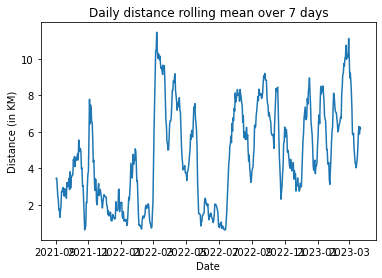

In [8]:
# 7 day rolling average of distance
df['Rolling7DMeanDistance'] = df.distance.rolling(window=7, center=True).mean()
fig, ax = plt.subplots()
ax.plot(df['creationDate'], df['Rolling7DMeanDistance'])
ax.set(title = 'Daily distance rolling mean over 7 days', 
       xlabel='Date',
       ylabel='Distance (in KM)')
# plt.figsize=(10, 8)

plt.savefig('output/7day_distance.png')

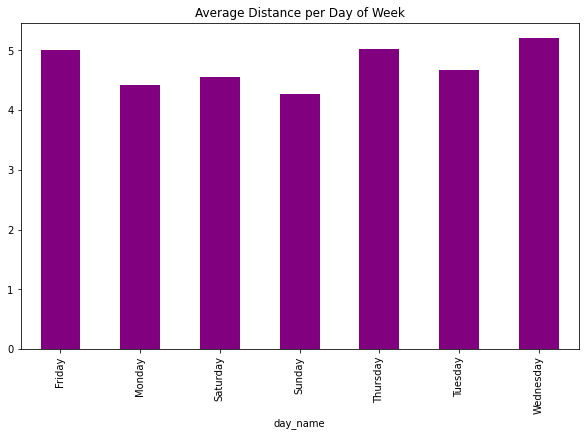

In [9]:
# Average distance per weekday
df.groupby("day_name")['distance'].agg('mean').plot.bar(color='purple',title='Average Distance per Day of Week', figsize=(10,6))
plt.savefig('output/avg_distance_weekDay.png')

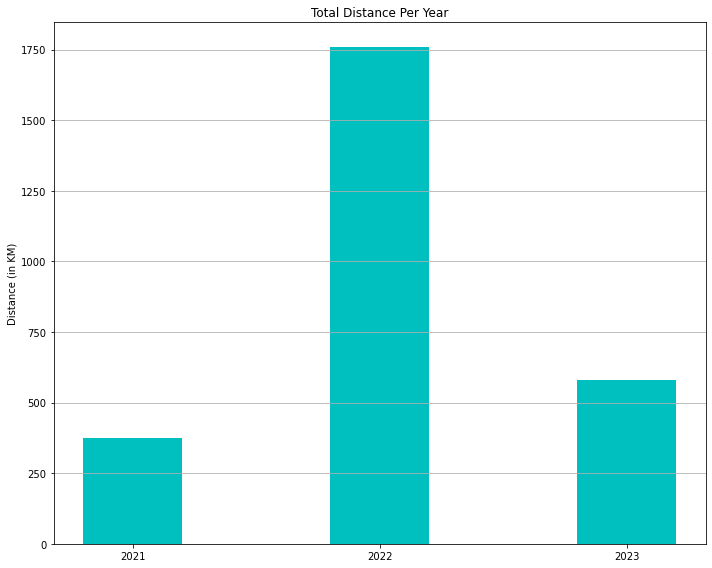

In [10]:
# distance by year
byyear = df.groupby("year", as_index=False)['distance'].sum()

fig, ax = plt.subplots(figsize=[10, 8])
ax.yaxis.grid(True)

bar_width = 0.4

fig = plt.bar(byyear.year, byyear.distance, bar_width,
                 alpha=1,
                 color='c',
                 label='Distance (in KM)')


ax.set(ylabel='Distance (in KM)', title='Total Distance Per Year',
       xticks=byyear.year)
# plt.legend()

plt.tight_layout()
plt.savefig('output/total_distance_pyear.png')

<AxesSubplot:xlabel='year', ylabel='month_name'>

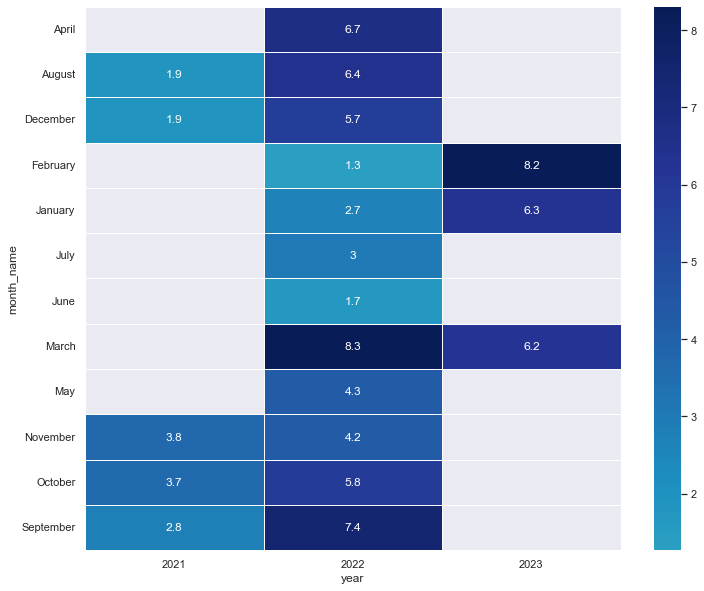

In [11]:
# Make heat map over average distance per day

sns.set_theme()

# Load the example month, date, distance total dataset and convert to long-form
dist_long = df.groupby(['year', 'month_name'], as_index=False)['distance'].mean()
dist = dist_long.pivot("month_name", "year", "distance")


# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(dist, annot=True, linewidths=.75, ax=ax, center=0, cmap="YlGnBu")

In [12]:
# average distance per month/year
dist_long = df.groupby(['year', 'month_name'], as_index=False)['distance'].mean()
dist_long

,year,month_name,distance
0,2021,August,1.851180
1,2021,December,1.886788
2,2021,November,3.754383
3,2021,October,3.711863
4,2021,September,2.783842
5,2022,April,6.705590
6,2022,August,6.417231
7,2022,December,5.712094
8,2022,February,1.266382
9,2022,January,2.709410


In [13]:
# add external variables

# dummy: 1 during covid, pre-vaccine, 0 otherwise/after 2 shots vaccine
df['covid'] = 0
df.loc[((df.year == 2020) & (df.month > 2) | (df.year == 2021) & (df.month > 2)), 'covid'] = 1

# dummy: 1 during holidays, 0 otherwise
df['holidays'] = 0
df.loc[(df.month == 5) | (df.month == 6), 'holidays'] = 1

<Figure size 864x864 with 0 Axes>

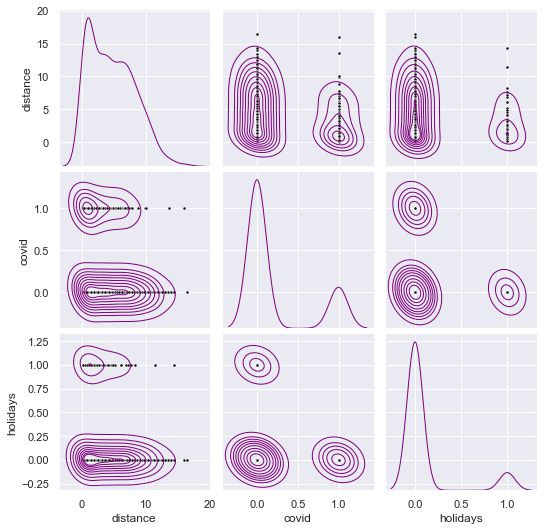

In [14]:
# pairwise plot
fig = plt.figure(figsize=(12, 12)) 

g = sns.pairplot(df[['distance', 'covid', 'holidays']], 
             kind='kde',
             plot_kws=dict(fill=False, color='purple', linewidths=1),
             diag_kws=dict(fill=False, color='purple', linewidth=1))

# add observation dots
g.map_offdiag(sns.scatterplot, marker='.', color='black')

<AxesSubplot:>

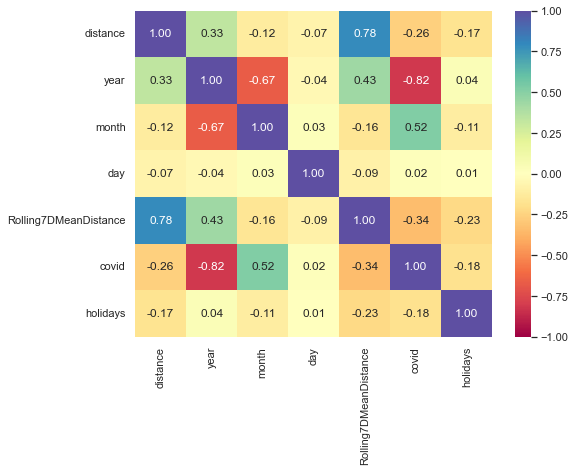

In [15]:
# correlation matrix
cm = df.corr()

# heatmap
fig = plt.figure(figsize=(8,6)) 
sns.heatmap(cm, annot=True, fmt=".2f", vmin=-1.0, vmax=+1.0, cmap='Spectral')

In [16]:
# OLS regression
model = smf.ols('distance ~ 1 + year + month + holidays + covid', data=df.dropna())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     26.44
Date:                Tue, 04 Apr 2023   Prob (F-statistic):           4.15e-20
Time:                        11:45:11   Log-Likelihood:                -1467.2
No. Observations:                 567   AIC:                             2944.
Df Residuals:                     562   BIC:                             2966.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5016.9360    944.942     -5.309      0.000   -6872.985   -3160.887
year           2.4833      0.467      5.315      0.000       1.566       3.401
month          0.1374      0.048      2.840      0.005       0.042       0.232
holidays      -2.0234      0.457     -4.423      0.000      -2.922      -1.125
covid         -0.2048      0.596     -0.343      0.731      -1.376       0.966
==============================================================================
Omnibus:                       36.651   Durbin-Watson:                   1.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.163
Skew:                           0.661   Prob(JB):                     6.99e-10
Kurtosis:                       3.194   Cond. No.                     1.41e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""